In [13]:
import pymc3 as pm
import numpy as np
import pandas as pd 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
plt.style.use("seaborn-darkgrid")
np.set_printoptions(precision=2)

/var/folders/zz/hwfwgc3s6wdfpwyj5z1s5y4m0000gn/T/ipykernel_65746/2537765814.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


n_total=215
mix.shape=(215,)


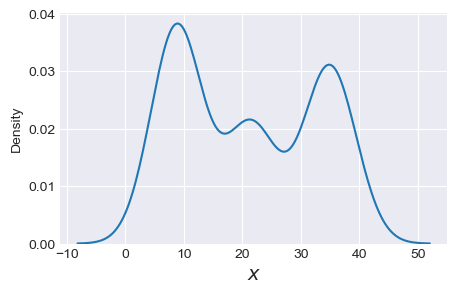

In [14]:
clusters = 3
n_cluster = [90, 50, 75]
n_total = sum(n_cluster)
print(f"{n_total=}")
means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))
print(f"{mix.shape=}")

plt.figure(figsize=(5,3))
sns.kdeplot(np.array(mix))
plt.xlabel("$x$", fontsize=14)
plt.savefig("img701.png")

In [16]:
a=np.ones(clusters)
a

array([1., 1., 1.])

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p]
>CategoricalGibbsMetropolis: [category]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 73 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/hiroakimatsumoto/miniforge3/envs/pymc3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


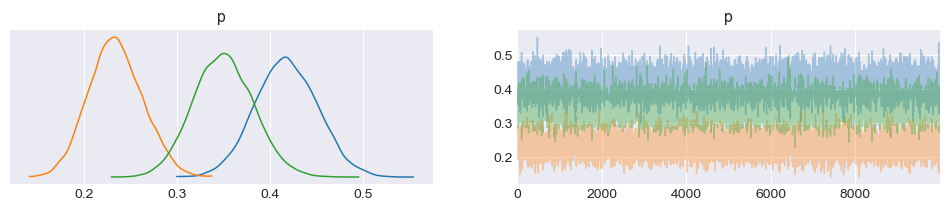

In [15]:
# 既知の正規分布混合モデルを出力する
with pm.Model() as model_kg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    category = pm.Categorical("category", p=p, shape=n_total)

    means = pm.math.constant([10, 20, 35])
    y = pm.Normal("y", mu=means[category], sigma=2, observed=mix)
    
    trace_kg = pm.sample(draws=10000, 
                          tune=1000,
                          chains=1,
                          return_inferencedata=False)

varnames_kg = ["p"]
az.plot_trace(trace_kg, varnames_kg)
plt.savefig("img704.png")

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [sigma, means, p]
>CategoricalGibbsMetropolis: [category]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 88 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/hiroakimatsumoto/miniforge3/envs/pymc3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


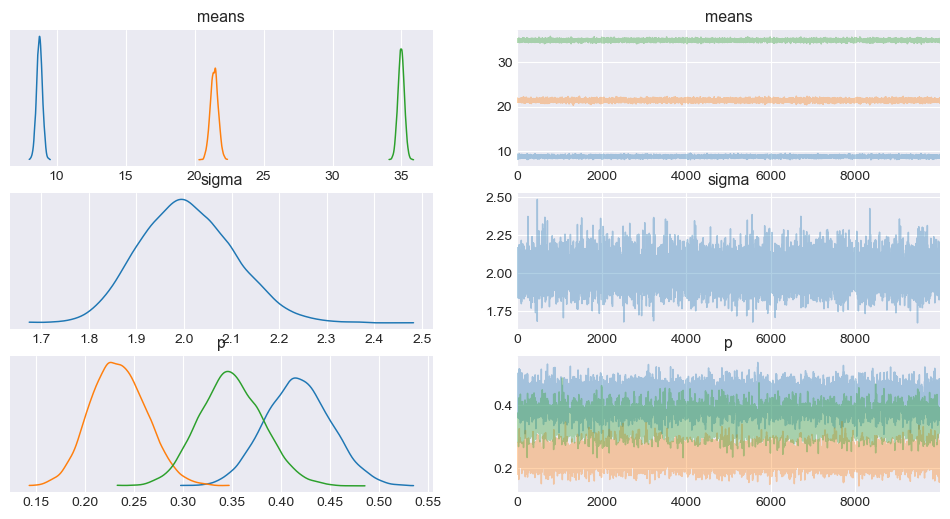

In [22]:
# 正規分布のパラメータを推定する
with pm.Model() as model_ug:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    category = pm.Categorical("category", p=p, shape=n_total)

    mean_list = [10, 20, 35]
    assert len(mean_list) == clusters
    means = pm.Normal("means", mu=mean_list, sigma=2, shape=clusters)
    sigma = pm.HalfCauchy("sigma", 5)
    y = pm.Normal("y", mu=means[category], sigma=sigma, observed=mix)

    trace_ug = pm.sample(draws=10000,
                         tune=1000,
                         chains=1,
                         return_inferencedata=False)

varnames_ug = ["means", "sigma", "p"]
az.plot_trace(trace_ug, varnames_ug)
plt.savefig("img705.png")
                          

### 事後予測チェック

In [24]:
# ようやく統計量
az.summary(trace_ug, varnames_ug)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/hiroakimatsumoto/miniforge3/envs/pymc3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],8.750,0.212,8.360,9.153,0.002,0.001,12971.0,7851.0,NaN
means[1],21.424,0.280,20.882,21.932,0.003,0.002,11018.0,7509.0,NaN
means[2],34.974,0.232,34.514,35.384,0.002,0.002,10137.0,7558.0,NaN
sigma,2.006,0.099,1.831,2.194,0.001,0.001,11150.0,7153.0,NaN
p[0],0.417,0.034,0.355,0.481,0.000,0.000,9397.0,8071.0,NaN
p[1],0.234,0.029,0.182,0.287,0.000,0.000,9015.0,8298.0,NaN
p[2],0.349,0.033,0.290,0.411,0.000,0.000,17127.0,7949.0,NaN


/Users/hiroakimatsumoto/miniforge3/envs/pymc3/lib/python3.10/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


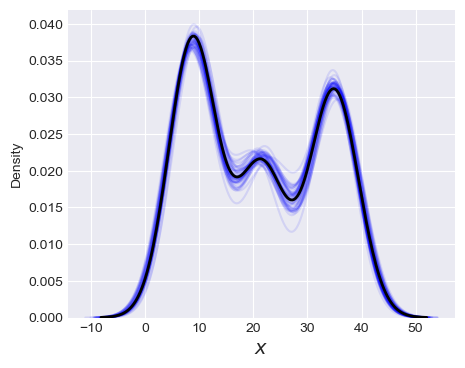

In [28]:
# 混合モデルの出力
ppc = pm.sample_posterior_predictive(trace=trace_ug,
                                     samples=50,
                                     model=model_ug)

plt.figure(figsize=(5,4))
for i in ppc["y"]:
    sns.kdeplot(i, alpha=0.1, color="b")

sns.kdeplot(np.array(mix), lw=2, color="k")
plt.xlabel("$x$", fontsize=14)
plt.savefig("img706.png")